<a href="https://colab.research.google.com/github/sanchitgulati/ML-notebooks/blob/main/OG_TF_GAN_TFV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Copyright 2018 The TensorFlow GAN Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# TF-GAN Tutorial

Tutorial authors: joelshor@, westbrook@


Updated for TensorFlow 2 : sanchitgulati@

In [2]:
%%capture
# Check that imports for the rest of the file work.
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
# Allow matplotlib images to render immediately.
%matplotlib inline

In [3]:
tf.__version__

'2.9.2'

## Unconditional MNIST with GANEstimator

This exercise uses TF-GAN's GANEstimator and the MNIST dataset to create a GAN for generating fake handwritten digits.

### MNIST

The [MNIST dataset](https://wikipedia.org/wiki/MNIST_database) contains tens of thousands of images of handwritten digits. We'll use these images to train a GAN to generate fake images of handwritten digits. This task is small enough that you'll be able to train the GAN in a matter of minutes.

### GANEstimator

TensorFlow's Estimator API that makes it easy to train models. TF-GAN offers `GANEstimator`, an Estimator for training GANs.

### Input Pipeline

We set up our input pipeline by defining an `input_fn`. in the "Train and Eval Loop" section below we pass this function to our GANEstimator's `train` method to initiate training.  The `input_fn`:

1.  Generates the random inputs for the generator.
2.  Uses `tensorflow_datasets` to retrieve the MNIST data.
3.  Uses the tf.data API to format the data.

In [4]:
import tensorflow_datasets as tfds

def input_fn(mode, params):
  assert 'batch_size' in params
  assert 'noise_dims' in params
  bs = params['batch_size']
  nd = params['noise_dims']
  split = 'train' if mode == tf.estimator.ModeKeys.TRAIN else 'test'
  shuffle = (mode == tf.estimator.ModeKeys.TRAIN)
  just_noise = (mode == tf.estimator.ModeKeys.PREDICT)
  
  noise_ds = (tf.data.Dataset.from_tensors(0).repeat()
              .map(lambda _: tf.random.normal([bs, nd])))
  
  if just_noise:
    return noise_ds

  def _preprocess(element):
    # Map [0, 255] to [-1, 1].
    images = (tf.cast(element['image'], tf.float32) - 127.5) / 127.5
    return images

  images_ds = (tfds.load('mnist:3.*.*', split=split)
               .map(_preprocess)
               .cache()
               .repeat())
  if shuffle:
    images_ds = images_ds.shuffle(
        buffer_size=10000, reshuffle_each_iteration=True)
  images_ds = (images_ds.batch(bs, drop_remainder=True)
               .prefetch(tf.data.experimental.AUTOTUNE))

  return tf.data.Dataset.zip((noise_ds, images_ds))

Download the data and sanity check the inputs.

TypeError: ignored

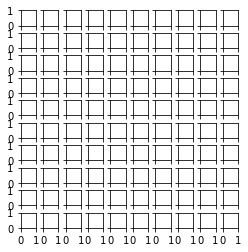

In [27]:
# from mpl_toolkits.axes_grid1 import ImageGrid

# params = {'batch_size': 100, 'noise_dims':64}
# with tf.Graph().as_default():
#   ds = input_fn(tf.estimator.ModeKeys.TRAIN, params)
#   numpy_imgs = next(iter(tfds.as_numpy(ds)))[1]

# fig = plt.figure(figsize=(4., 4.))
# grid = ImageGrid(fig, 111,  # similar to subplot(111)
#                  nrows_ncols=(10, 10),  # creates 2x2 grid of axes
#                  axes_pad=0.1,  # pad between axes in inch.
#                  )

# for ax, im in zip(grid, numpy_imgs):
#   # Iterating over the grid returns the Axes.
#   rgb_image_data = np.stack((im, im, im), axis=-1)  
#   ax.imshow(rgb_image_data)

# plt.show()

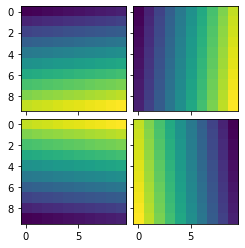

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

im1 = np.arange(100).reshape((10, 10))
im2 = im1.T
im3 = np.flipud(im1)
im4 = np.fliplr(im2)

im1
fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

### Neural Network Architecture

To build our GAN we need two separate networks:

*  A generator that takes input noise and outputs generated MNIST digits
*  A discriminator that takes images and outputs a probability of being real or fake

We define functions that build these networks. In the GANEstimator section below we pass the builder functions to the `GANEstimator` constructor. `GANEstimator` handles hooking the generator and discriminator together into the GAN. 


In [ ]:
from tensorflow.keras.layers import Dense,BatchNormalization,Conv2DTranspose,Conv2D

def _dense(units, l2_weight):
  return Dense(units, None,
      kernel_initializer=tf.keras.initializers.glorot_uniform,
      kernel_regularizer=tf.keras.regularizers.l2(l=l2_weight),
      bias_regularizer=tf.keras.regularizers.l2(l=l2_weight))

def _batch_norm():
  return BatchNormalization(momentum=0.999, epsilon=0.001)

def _deconv2d(filters, kernel_size, stride, l2_weight):
  return Conv2DTranspose(filters, [kernel_size, kernel_size], strides=[stride, stride], 
      activation=tf.nn.relu, padding='same',
      kernel_initializer=tf.keras.initializers.glorot_uniform,
      kernel_regularizer=tf.keras.regularizers.l2(l=l2_weight),
      bias_regularizer=tf.keras.regularizers.l2(l=l2_weight))

def _conv2d(filters, kernel_size, stride, l2_weight):
  return Conv2D(filters, [kernel_size, kernel_size], strides=[stride, stride], 
      activation=None, padding='same',
      kernel_initializer=tf.keras.initializers.glorot_uniform,
      kernel_regularizer=tf.keras.regularizers.l2(l=l2_weight),
      bias_regularizer=tf.keras.regularizers.l2(l=l2_weight))

### unconditional_generator

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ReLU,Reshape,Activation

def unconditional_generator(noise):
  model = Sequential() #Here we initiate the sequential model
  """Generator to produce unconditional MNIST images."""
  weight_decay=2.5e-5
  units = 1024
  height = 28
  width = 28
  channels = 1

  model.add(tf.keras.Input(shape=(28, 28, 1)))
  model.add(_dense(units, weight_decay))
  model.add(_batch_norm())
  model.add(ReLU())
  model.add(_dense(7 * 7 * 256, weight_decay))
  model.add(_batch_norm())
  model.add(ReLU())
  model.add(_conv2d(filters=64, kernel_size=4, stride=2,l2_weight = weight_decay))
  model.add(_deconv2d(filters=64, kernel_size=4,stride=2, l2_weight=weight_decay))
  # Make sure that generator output is in the same range as `inputs`
  # ie [-1, 1].
  model.add(_conv2d(filters=1, kernel_size=4, stride=1, l2_weight=0.0))
  model.add(Activation(tf.tanh))
  return model.outputs[0]

### unconditional_discriminator

In [ ]:
from tensorflow.keras.layers import LeakyReLU,Flatten


def unconditional_discriminator(img, conditioning):
  weight_decay=2.5e-5
  model = Sequential() #Here we initiate the sequential model
  # del conditioning
  
  model.add(tf.keras.Input(shape=(28, 28, 1)))
  model.add(_conv2d(64, 4, 2, weight_decay))
  model.add(LeakyReLU())
  
  model.add(_conv2d(128, 4, 2, weight_decay))
  model.add(LeakyReLU())
  model.add(Flatten())
  model.add(_dense(1024, weight_decay))
  model.add(_batch_norm())
  model.add(LeakyReLU())
  model.add(_dense(1, weight_decay))

  return model.outputs[0]

### Evaluating Generative Models, and evaluating GANs


TF-GAN provides some standard methods of evaluating generative models. In this example, we measure:

*  Inception Score: called `mnist_score` below.
*  Frechet Inception Distance

We apply a pre-trained classifier to both the real data and the generated data calculate the *Inception Score*.  The Inception Score is designed to measure both quality and diversity. See [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) by Salimans et al for more information about the Inception Score.

*Frechet Inception Distance* measures how close the generated image distribution is to the real image distribution.  See [GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium](https://arxiv.org/abs/1706.08500) by Heusel et al for more information about the Frechet Inception distance.

In [ ]:
from tensorflow_gan.examples.mnist import util as eval_util
import os

def get_eval_metric_ops_fn(gan_model):
  real_data_logits = tf.reduce_mean(gan_model.discriminator_real_outputs)
  gen_data_logits = tf.reduce_mean(gan_model.discriminator_gen_outputs)
  real_mnist_score = eval_util.mnist_score(gan_model.real_data)
  generated_mnist_score = eval_util.mnist_score(gan_model.generated_data)
  frechet_distance = eval_util.mnist_frechet_distance(
      gan_model.real_data, gan_model.generated_data)
  return {
      'real_data_logits': tf.metrics.mean(real_data_logits),
      'gen_data_logits': tf.metrics.mean(gen_data_logits),
      'real_mnist_score': tf.metrics.mean(real_mnist_score),
      'mnist_score': tf.metrics.mean(generated_mnist_score),
      'frechet_distance': tf.metrics.mean(frechet_distance),
  }

### GANEstimator

The `GANEstimator` assembles and manages the pieces of the whole GAN model. The `GANEstimator` constructor takes the following compoonents for both the generator and discriminator:

*  Network builder functions: we defined these in the "Neural Network Architecture" section above.
*  Loss functions: here we use the wasserstein loss for both.
*  Optimizers: here we use `tf.train.AdamOptimizer` for both generator and discriminator training.

In [ ]:
# Get the global step variable

train_batch_size = 32 #@param
noise_dimensions = 64 #@param
generator_lr = 0.001 #@param
discriminator_lr = 0.0002 #@param
beta_1 = 0.5  #@param
params_fn = {'mode':tf.estimator.ModeKeys.TRAIN,'batch_size': train_batch_size, 'noise_dims': noise_dimensions}


gan_estimator = tfgan.estimator.GANEstimator(
    generator_fn=unconditional_generator,
    discriminator_fn=unconditional_discriminator,
    generator_loss_fn=tfgan.losses.wasserstein_generator_loss,
    discriminator_loss_fn=tfgan.losses.wasserstein_discriminator_loss,
    params=params_fn,
    generator_optimizer= tf.compat.v1.train.AdamOptimizer(generator_lr, 0.5),
    discriminator_optimizer= tf.compat.v1.train.AdamOptimizer(discriminator_lr, 0.5),
    get_eval_metric_ops_fn=get_eval_metric_ops_fn)

### Train and eval loop

The `GANEstimator`'s `train()` method initiates GAN training, including the alternating generator and discriminator training phases.

The loop in the code below calls `train()` repeatedly in order to periodically display generator output and evaluation results. But note that the code below does not manage the alternation between discriminator and generator: that's all handled automatically by `train()`.

In [ ]:
gan_estimator

In [ ]:
# # Disable noisy output.
# tf.autograph.set_verbosity(0, False)

# import time
# steps_per_eval = 500 
# max_train_steps = 5000
# batches_for_eval_metrics = 100

# # Used to track metrics.
# steps = []
# real_logits, fake_logits = [], []
# real_mnist_scores, mnist_scores, frechet_distances = [], [], []

# cur_step = 0
# start_time = time.time()
# while cur_step < max_train_steps:
#   next_step = min(cur_step + steps_per_eval, max_train_steps)

#   start = time.time()
#   gan_estimator.train(input_fn, max_steps=next_step)
#   steps_taken = next_step - cur_step
#   time_taken = time.time() - start
#   print('Time since start: %.2f min' % ((time.time() - start_time) / 60.0))
#   print('Trained from step %i to %i in %.2f steps / sec' % (
#       cur_step, next_step, steps_taken / time_taken))
#   cur_step = next_step
  
#   # Calculate some metrics.
#   metrics = gan_estimator.evaluate(input_fn, steps=batches_for_eval_metrics)
#   steps.append(cur_step)
#   real_logits.append(metrics['real_data_logits'])
#   fake_logits.append(metrics['gen_data_logits'])
#   real_mnist_scores.append(metrics['real_mnist_score'])
#   mnist_scores.append(metrics['mnist_score'])
#   frechet_distances.append(metrics['frechet_distance'])
#   print('Average discriminator output on Real: %.2f  Fake: %.2f' % (
#       real_logits[-1], fake_logits[-1]))
#   print('Inception Score: %.2f / %.2f  Frechet Distance: %.2f' % (
#       mnist_scores[-1], real_mnist_scores[-1], frechet_distances[-1]))
  
#   # Vizualize some images.
#   iterator = gan_estimator.predict(
#       input_fn, hooks=[tf.train.StopAtStepHook(num_steps=21)])
#   try:
#     imgs = np.array([next(iterator) for _ in range(20)])
#   except StopIteration:
#     pass
#   tiled = tfgan.eval.python_image_grid(imgs, grid_shape=(2, 10))
#   plt.axis('off')
#   plt.imshow(np.squeeze(tiled))
#   plt.show()
  
  
# # Plot the metrics vs step.
# plt.title('MNIST Frechet distance per step')
# plt.plot(steps, frechet_distances)
# plt.figure()
# plt.title('MNIST Score per step')
# plt.plot(steps, mnist_scores)
# plt.plot(steps, real_mnist_scores)
# plt.show()